In [13]:
database_path = 'D:/iliapl/topic_modeling/data/databases/53k_individual_hcps_70_percent_confidence_tweets.db'
all_emotions_path = 'D:/iliapl/topic_modeling/data/emotion_recognition/53k_individual_hcp_authors/all_tweet_emotions.csv'

global_confirmed_path = r'D:\iliapl\topic_modeling\data\databases\COVID-19-master\csse_covid_19_data\csse_covid_19_time_series\time_series_covid19_confirmed_global.csv'
global_death_path = r'D:\iliapl\topic_modeling\data\databases\COVID-19-master\csse_covid_19_data\csse_covid_19_time_series\time_series_covid19_deaths_global.csv'
us_confirmed_path = r'D:\iliapl\topic_modeling\data\databases\COVID-19-master\csse_covid_19_data\csse_covid_19_time_series\time_series_covid19_confirmed_US.csv'
us_death_path = r'D:\iliapl\topic_modeling\data\databases\COVID-19-master\csse_covid_19_data\csse_covid_19_time_series\time_series_covid19_deaths_US.csv'

In [3]:
import sqlite3 as sql
import pandas as pd
import time

con = sql.connect(database_path)

T = time.time()

tweet_dates = pd.read_sql('SELECT post_id, date FROM posts', con)

# if we don't do this, merging takes a very very long time
tweet_dates = tweet_dates[~tweet_dates['post_id'].isnull()]
tweet_dates['post_id'] = tweet_dates['post_id'].astype('int64')

print(f'Loaded tweet dates in {time.time() - T} seconds')

T = time.time()

all_emotions_df = pd.read_csv(all_emotions_path)

# if we don't do this, merging takes a very very long time
all_emotions_df = all_emotions_df[~all_emotions_df['post_id'].isnull()]
all_emotions_df['post_id'] = all_emotions_df['post_id'].astype('int64')

print(f'Loaded emotions in {time.time() - T} seconds')

Loaded tweet dates in 95.80935168266296 seconds
Loaded emotions in 118.86290955543518 seconds


In [4]:
T = time.time()

merged_df = tweet_dates.merge(all_emotions_df, on='post_id', how='inner')

print(f'Merged dataframes in {time.time() - T} seconds')

Merged dataframes in 39.6539032459259 seconds


In [150]:
num_frames = 50
#min_date = merged_df['date'].min()
#min_date = min_date[:min_date.index(' J')]
min_date = '2020-01-01 00:00:00'
max_date = merged_df['date'].max()
max_date = max_date[:max_date.index(' J')]

In [151]:
from datetime import datetime

def date_range(start, end, intv):
    start = datetime.strptime(start, "%Y-%m-%d %H:%M:%S")
    end = datetime.strptime(end, "%Y-%m-%d %H:%M:%S")
    diff = (end  - start) / intv
    for i in range(intv):
        yield (start + diff * i).strftime("%Y-%m-%d %H:%M:%S")
    yield end.strftime("%Y-%m-%d %H:%M:%S")

In [152]:
frame_separators = list(date_range(min_date, max_date, num_frames))
date_windows = [(frame_separators[i], frame_separators[i+1]) for i in range(len(frame_separators) - 1)]

In [222]:
from tqdm import tqdm

def get_aggregated_emotions(min_date, max_date, num_frames):
    
    frame_separators = list(date_range(min_date, max_date, num_frames))
    date_windows = [(frame_separators[i], frame_separators[i+1]) for i in range(len(frame_separators) - 1)]
    
    aggregate_emotions_df = pd.DataFrame(columns=['start_date', 'end_date', 'Anger', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise'])

    for i, (start_date, end_date) in enumerate(tqdm(date_windows, position=0, leave=True)):
        if i < len(date_windows) - 1:
            window_tweets = merged_df[(merged_df['date'] >= start_date) & (merged_df['date'] < end_date)]
        else:
            window_tweets = merged_df[(merged_df['date'] >= start_date) & (merged_df['date'] <= end_date)]

        # get aggregate emotions for this window
        entry_to_append = {'start_date': start_date, 'end_date': end_date}
        for emotion in ['Anger', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise']:
            entry_to_append[emotion] = window_tweets[emotion].mean()

        aggregate_emotions_df = aggregate_emotions_df.append(entry_to_append, ignore_index=True)
        
    return aggregate_emotions_df

In [193]:
aggregate_emotions_df = get_aggregated_emotions(min_date, max_date, num_frames)


100%|██████████████████████████████████████████| 50/50 [03:18<00:00,  3.98s/it]


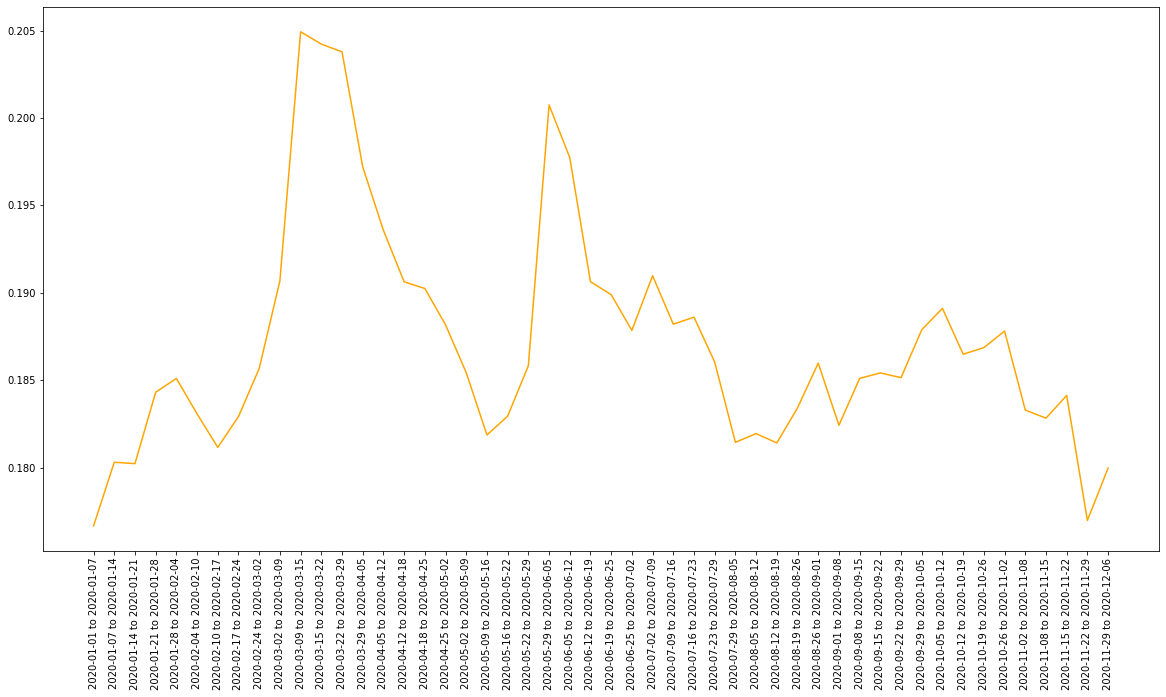

In [194]:
import matplotlib.pyplot as plt

colors = ['red', 'brown', 'orange', 'limegreen', 'grey', 'deepskyblue']

#ax = aggregate_emotions_df.plot(kind='area', stacked=True, color=colors, figsize=(20, 10))
ax = aggregate_emotions_df['Fear'].plot(color='orange', figsize=(20, 10))
ax.set_xticks(aggregate_emotions_df.index)
ax.set_xticklabels(['{} to {}'.format(entry[1][:entry[1].index(' ')], entry[2][:entry[2].index(' ')]) for entry in aggregate_emotions_df[['start_date', 'end_date']].itertuples()], rotation=90)
plt.show()

## Cross-correlation between fear and confirmed/death case deltas

In [227]:
def get_aggregated_emotions_by_dates(date_list):
    # each date in the list represents the beginning of a time frame
    
    frame_separators = date_list
    date_windows = [(frame_separators[i], frame_separators[i+1]) for i in range(len(frame_separators) - 1)]
    
    aggregate_emotions_df = pd.DataFrame(columns=['start_date', 'end_date', 'Anger', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise'])

    for i, (start_date, end_date) in enumerate(tqdm(date_windows, position=0, leave=True)):
        if i < len(date_windows) - 1:
            window_tweets = merged_df[(merged_df['date'] >= start_date) & (merged_df['date'] < end_date)]
        else:
            window_tweets = merged_df[(merged_df['date'] >= start_date) & (merged_df['date'] <= end_date)]

        # get aggregate emotions for this window
        entry_to_append = {'start_date': start_date, 'end_date': end_date}
        for emotion in ['Anger', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise']:
            entry_to_append[emotion] = window_tweets[emotion].mean()

        aggregate_emotions_df = aggregate_emotions_df.append(entry_to_append, ignore_index=True)
        
    return aggregate_emotions_df

In [155]:
# check cross correlation between FEAR itself (not deltas) and CONFIRMED DELTAS or DEATH DELTAS

global_confirmed_cases = pd.read_csv(global_confirmed_path)

In [183]:
max_date

'2020-12-06 01:59:59'

In [185]:
last_date_exclusive = '12/7/20'

In [186]:
global_confirmed_cases_data_only = global_confirmed_cases.drop(['Province/State', 'Country/Region', 'Lat', 'Long'] +
                                                               list(global_confirmed_cases.columns)[list(global_confirmed_cases.columns).index(last_date_exclusive):], axis=1)
global_new_confirmed_cases = global_confirmed_cases_data_only.diff(axis=1).drop('1/22/20', axis=1).sum(axis=0)

In [432]:
frame_time_days = 14
num_frames = len(global_new_confirmed_cases) // frame_time_days

global_new_confirmed_cases_split_array = np.array_split(global_new_confirmed_cases, num_frames)

In [433]:
import numpy as np

global_new_confirmed_cases_avg_frames = pd.Series([series.mean() for series in global_new_confirmed_cases_split_array],
                                                 index=[series.index[0] for series in global_new_confirmed_cases_split_array])

In [434]:
global_new_confirmed_cases_avg_frames

1/23/20       2016.400000
2/7/20        3069.200000
2/22/20       1950.466667
3/8/20       15873.800000
3/23/20      65674.600000
4/7/20       82716.666667
4/22/20      80129.533333
5/7/20       89611.666667
5/22/20     111091.133333
6/6/20      135135.600000
6/21/20     177005.666667
7/6/20      217608.357143
7/20/20     255207.357143
8/3/20      257644.428571
8/17/20     253925.285714
8/31/20     271619.214286
9/14/20     292806.285714
9/28/20     315571.500000
10/12/20    393517.000000
10/26/20    534277.714286
11/9/20     589347.214286
11/23/20    601906.857143
dtype: float64

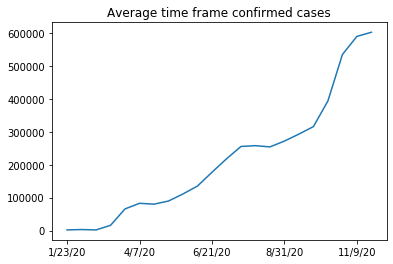

In [435]:
global_new_confirmed_cases_avg_frames.plot()
plt.title('Average time frame confirmed cases')
plt.show()

In [436]:
global_new_confirmed_cases_avg_frames_deltas = global_new_confirmed_cases_avg_frames.diff()
global_new_confirmed_cases_avg_frames_deltas = global_new_confirmed_cases_avg_frames_deltas[1:]

In [437]:
num_frames

22

In [438]:
global_new_confirmed_cases_avg_frames_deltas.index

Index(['2/7/20', '2/22/20', '3/8/20', '3/23/20', '4/7/20', '4/22/20', '5/7/20',
       '5/22/20', '6/6/20', '6/21/20', '7/6/20', '7/20/20', '8/3/20',
       '8/17/20', '8/31/20', '9/14/20', '9/28/20', '10/12/20', '10/26/20',
       '11/9/20', '11/23/20'],
      dtype='object')

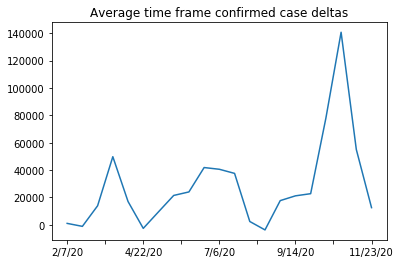

In [439]:
global_new_confirmed_cases_avg_frames_deltas.plot()
plt.title('Average time frame confirmed case deltas')
plt.show()

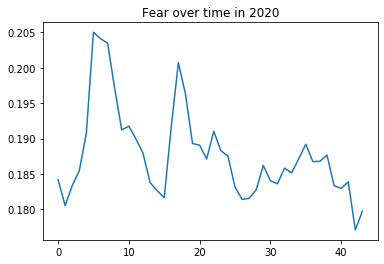

In [440]:
aggregated_emotions_for_cross_correlation['Fear'].plot()
plt.title('Fear over time in 2020')
plt.show()

In [441]:
def date_slash_to_dash(slash_date):
    return datetime.strftime(datetime.strptime(slash_date, '%m/%d/%y'), '%Y-%m-%d')

In [442]:
aggregated_emotions_for_cross_correlation = get_aggregated_emotions_by_dates([date_slash_to_dash(date) for date in 
                                                                              list(global_new_confirmed_cases_avg_frames_deltas.index) + ['12/06/20']])

100%|██████████████████████████████████████████| 21/21 [01:03<00:00,  3.02s/it]


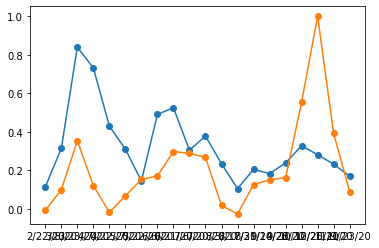

In [443]:
# Look at the graphs with a lag of one period

agg_emotions = (aggregated_emotions_for_cross_correlation['Fear'] - min(aggregated_emotions_for_cross_correlation['Fear'])) / 0.03
agg_emotions = agg_emotions[:-1]
plt.plot(agg_emotions, '-o')

normalized_global_new_confirmed_cases_avg_frames_deltas = global_new_confirmed_cases_avg_frames_deltas / max(global_new_confirmed_cases_avg_frames_deltas)
normalized_global_new_confirmed_cases_avg_frames_deltas = normalized_global_new_confirmed_cases_avg_frames_deltas[1:]
plt.plot(normalized_global_new_confirmed_cases_avg_frames_deltas, '-o')
plt.show()

In [444]:
pearsonr(agg_emotions[:16], normalized_global_new_confirmed_cases_avg_frames_deltas[:16])

(0.5401425795208191, 0.030781091299863873)

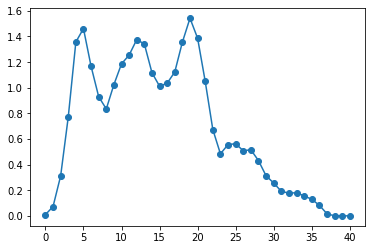

In [445]:
plt.plot(np.correlate((aggregated_emotions_for_cross_correlation['Fear'] - min(aggregated_emotions_for_cross_correlation['Fear'])) / 0.03,
            global_new_confirmed_cases_avg_frames_deltas / max(global_new_confirmed_cases_avg_frames_deltas), 'full'), '-o')

In [446]:
np.argmax(np.correlate((aggregated_emotions_for_cross_correlation['Fear'] - min(aggregated_emotions_for_cross_correlation['Fear'])) / 0.03,
            global_new_confirmed_cases_avg_frames_deltas / max(global_new_confirmed_cases_avg_frames_deltas), 'full'))

19

In [447]:
global_death_cases = pd.read_csv(global_death_path)

In [448]:
global_death_cases_data_only = global_death_cases.drop(['Province/State', 'Country/Region', 'Lat', 'Long'] + list(global_confirmed_cases.columns)[list(global_confirmed_cases.columns).index(last_date_exclusive):], axis=1)
global_new_death_cases = global_death_cases_data_only.diff(axis=1).drop('1/22/20', axis=1).sum(axis=0)

In [449]:
global_new_death_cases_split_array = np.array_split(global_new_death_cases, num_frames)

In [450]:
global_new_death_cases_avg_frames = pd.Series([series.mean() for series in global_new_death_cases_split_array],
                                                 index=[series.index[0] for series in global_new_death_cases_split_array])

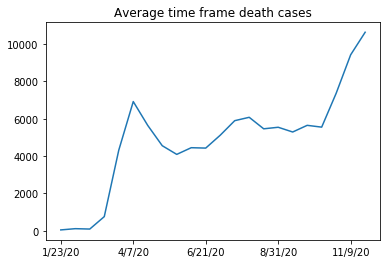

In [451]:
global_new_death_cases_avg_frames.plot()
plt.title('Average time frame death cases')
plt.show()

In [452]:
global_new_death_cases_avg_frames_deltas = global_new_death_cases_avg_frames.diff()
global_new_death_cases_avg_frames_deltas = global_new_death_cases_avg_frames_deltas[1:]

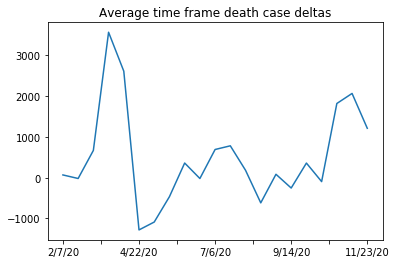

In [453]:
global_new_death_cases_avg_frames_deltas.plot()
plt.title('Average time frame death case deltas')
plt.show()

In [454]:
from scipy.stats import pearsonr

pearsonr(global_new_death_cases_avg_frames_deltas, list(aggregated_emotions_for_cross_correlation['Fear']))

(0.3157392379566165, 0.16323578617591283)

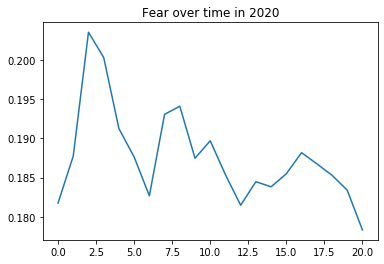

In [455]:
aggregated_emotions_for_cross_correlation['Fear'].plot()
plt.title('Fear over time in 2020')
plt.show()

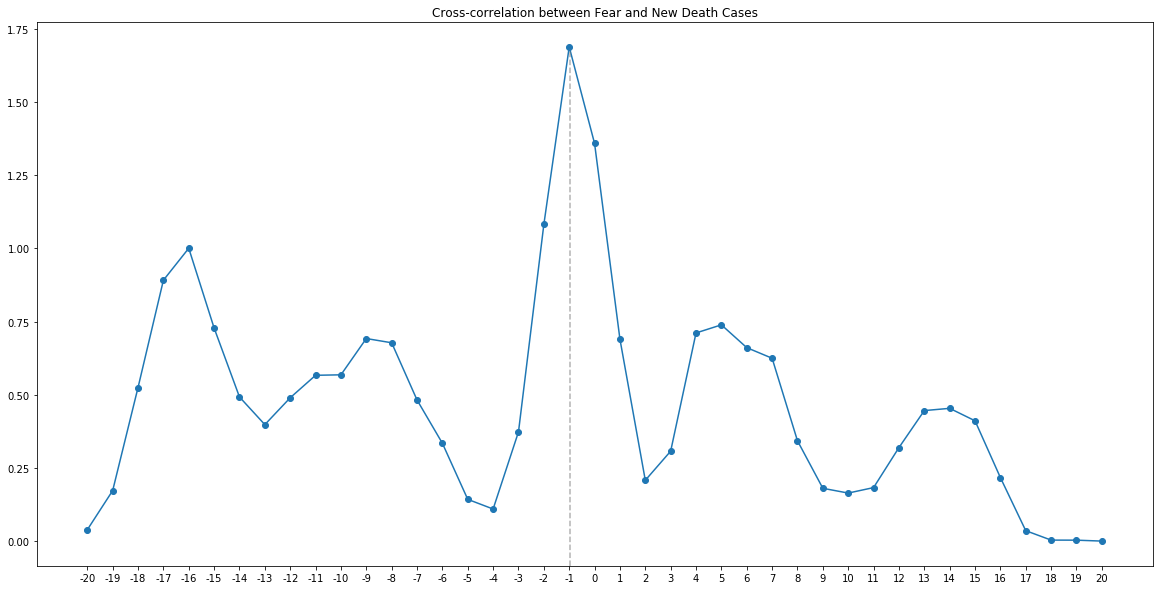

In [464]:
fear_new_deaths_cross_correlation = np.correlate((aggregated_emotions_for_cross_correlation['Fear'] - min(aggregated_emotions_for_cross_correlation['Fear'])) / 0.03,
            global_new_death_cases_avg_frames_deltas / max(global_new_death_cases_avg_frames_deltas), 'full')
num_points = len(global_new_death_cases_avg_frames_deltas)

plt.figure(figsize=(20, 10))
plt.plot(fear_new_deaths_cross_correlation, '-o')
plt.xticks(list(range(len(fear_new_deaths_cross_correlation))),labels=[x - num_points + 1 for x in range(len(fear_new_deaths_cross_correlation))])
plt.axvline(19.05, ymax=0.95, alpha=0.6, color='grey', ls='--')
plt.title('Cross-correlation between Fear and New Death Cases')
plt.show()

In [457]:
# + 1 because if we have 21 points, index 20 is 0 displacement

print('Displacement with highest correlation:', np.argmax(fear_new_deaths_cross_correlation) - num_points + 1)

Displacement with highest correlation: -1


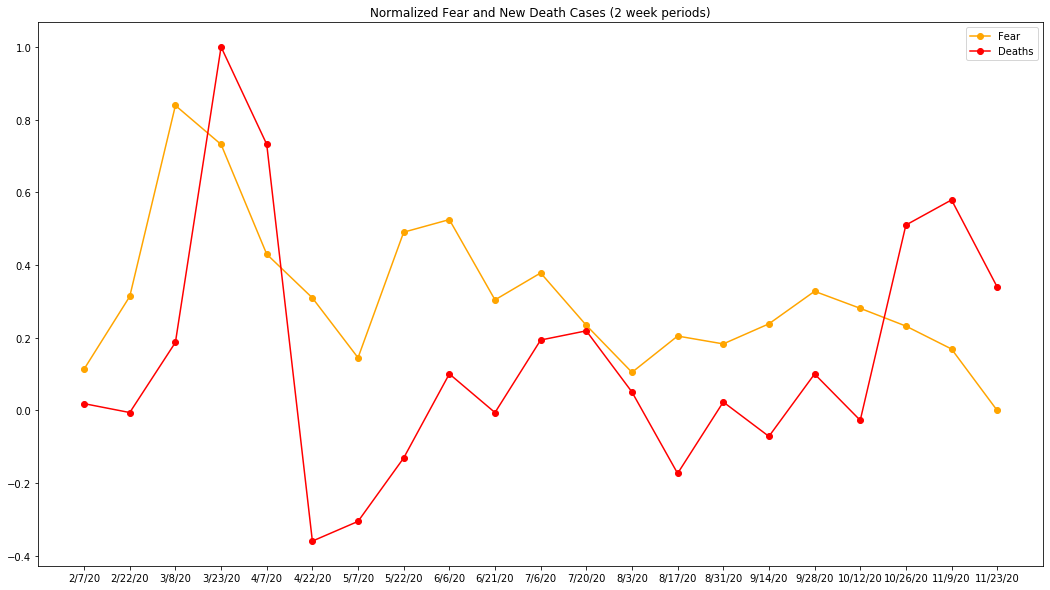

In [459]:
# No displacement

plt.figure(figsize=(18, 10))
plt.plot((aggregated_emotions_for_cross_correlation['Fear'] - min(aggregated_emotions_for_cross_correlation['Fear'])) / 0.03, '-o', color='orange')
plt.plot(global_new_death_cases_avg_frames_deltas / max(global_new_death_cases_avg_frames_deltas), '-o', color='red')
plt.legend(['Fear', 'Deaths'])
plt.title('Normalized Fear and New Death Cases (2 week periods)')
plt.show()

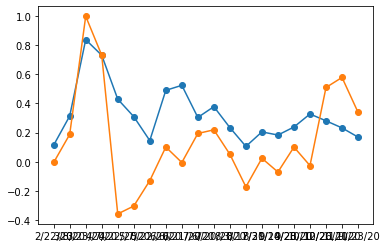

In [465]:
# Lag of one points

agg_emotions = (aggregated_emotions_for_cross_correlation['Fear'] - min(aggregated_emotions_for_cross_correlation['Fear'])) / 0.03
agg_emotions = agg_emotions[:-1]
plt.plot(agg_emotions, '-o')

normalized_global_new_death_cases_avg_frames_deltas = global_new_death_cases_avg_frames_deltas / max(global_new_death_cases_avg_frames_deltas)
normalized_global_new_death_cases_avg_frames_deltas = normalized_global_new_death_cases_avg_frames_deltas[1:]
plt.plot(normalized_global_new_death_cases_avg_frames_deltas, '-o')
plt.show()

In [466]:
pearsonr(agg_emotions, normalized_global_new_death_cases_avg_frames_deltas)

(0.5668405722028146, 0.009157794491483547)

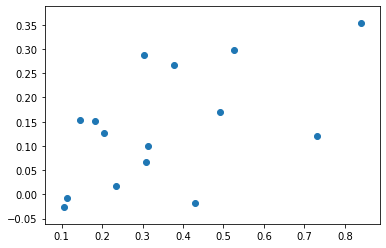

In [462]:
plt.scatter(agg_emotions[:15], normalized_global_new_confirmed_cases_avg_frames_deltas[:15])